## Model Data:

### Trimmed Outliers

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import plotly.express as px
# plt.style.use('bmh')
import warnings
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=[SettingWithCopyWarning, FutureWarning])

import jenkspy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn import linear_model

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import power_transform

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

## IMPORT DATA

In [30]:
# import executive compensation data
df = pd.read_csv('02.data/executive_comp_data.csv')

In [31]:
# fillna for formation_year
# I may want to do this with random forest instead
df.formation_yr.fillna(df.formation_yr.mean(), inplace=True)

In [6]:
df.isna().sum()

ein                          0
period                       0
title                      268
trustee_or_director          0
institutional_trustee    40051
officer                  21102
key_employee             39207
highest_compensated      39470
reportable_comp              0
org_name                     0
subsection                   0
ntee_code                    0
ntee_description             0
state                      115
formation_yr                 0
assets                       0
liabilities                  0
expenses                     0
revenue                      0
ntee_letter                  0
dtype: int64

(array([   17.,    44.,   521.,  3152.,  7626., 10617., 13059.,  4524.,
          510.,    27.]),
 array([ 0.        ,  1.68895881,  3.37791762,  5.06687643,  6.75583524,
         8.44479405, 10.13375286, 11.82271167, 13.51167048, 15.20062929,
        16.8895881 ]),
 <a list of 10 Patch objects>)

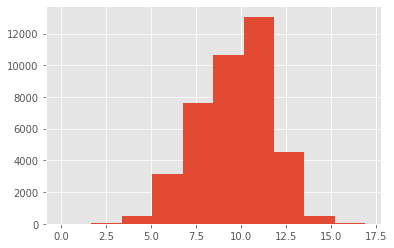

In [8]:
plt.hist(df.reportable_comp.transform(np.log))

In [9]:
df.reportable_comp = df.reportable_comp.transform(np.log)

In [10]:
# assign X and y variables
y = df.reportable_comp.transform(np.log)
X = pd.get_dummies(df[['subsection',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']])

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
rfr = ensemble.RandomForestRegressor()

rfr.fit(X, y)

cross_val_score(rfr, X, y, cv=5)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



array([0.156922  , 0.15537804, 0.16659893, 0.02644972, 0.10696747])

Using log transform to remove outliers from compensation only helped a little bit.

### Remove outliers on the small end of the spectrum

In [36]:
df.reportable_comp.mode()

0    1000.0
dtype: float64

In [41]:
df.reportable_comp.quantile(.5)

19200.0

In [35]:
df.reportable_comp.clip(lower=df.reportable_comp.quantile(.1))

0        55385.0
1        60000.0
2        71062.0
3         9010.0
4        87452.0
          ...   
40092    12000.0
40093    39880.0
40094    50288.0
40095    48188.0
40096     9000.0
Name: reportable_comp, Length: 40097, dtype: float64

In [373]:
# trim at 90th percentile
# for column in df_eda.iloc[:,-5:]:
#     df_eda[column].clip(upper=df_eda[column].quantile(.9), inplace=True)

In [42]:
# assign X and y variables
y = df.reportable_comp.clip(lower=df.reportable_comp.quantile(.5))
X = pd.get_dummies(df[['subsection',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']])

In [109]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [38]:
y.shape

(40097,)

In [25]:
X.shape

(40097, 105)

In [44]:
rfr = ensemble.RandomForestRegressor()

rfr.fit(X, y)

cross_val_score(rfr, X, y, cv=10)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



array([ 0.31929251,  0.06124194, -0.25014639, -0.06289318, -0.05428664,
        0.01644177,  0.05698841, -0.10274868, -0.39182427, -0.10742395])

Trimming outliers on the low side seems to help to some extent.

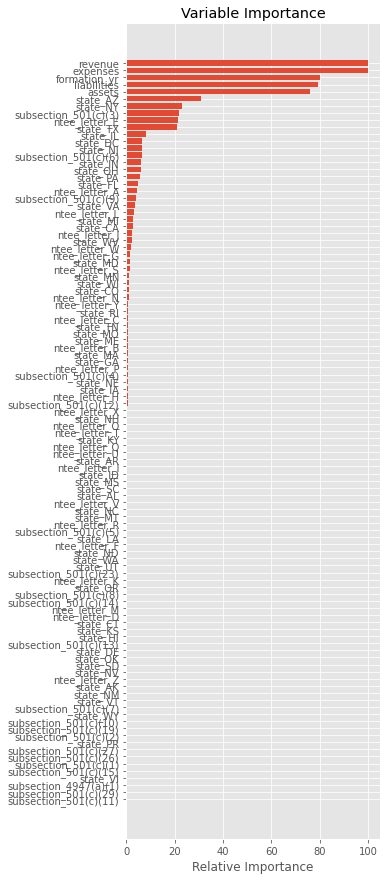

In [45]:
# visualize feature importances
plt.figure(figsize=(10, 15))

feature_importance = 100.0 * (rfr.feature_importances_ / rfr.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');